# Example of combining multiple thresholders to an outlier score. 

Three combination frameworks are demonstrated in this example:

1. Mean: take the mean of all threshold labels 
2. Median : take the median of all threshold labels 
3. Gmean : take the geometric mean of all threshold labels 

In [1]:
from __future__ import division
from __future__ import print_function

import os
import sys

# temporary solution for relative imports in case pyod is not installed
# if pyod is installed, no need to use the following line
sys.path.append(os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
from scipy import stats

from pyod.models.knn import KNN
from pyod.models.iforest import IForest

from pythresh.thresholds.iqr import IQR
from pythresh.thresholds.mad import MAD
from pythresh.thresholds.fwfm import FWFM
from pythresh.thresholds.yj import YJ
from pythresh.thresholds.kmeans import KMEANS
from pythresh.thresholds.zscore import ZSCORE
from pythresh.thresholds.aucp import AUCP
from pythresh.thresholds.qmcd import QMCD
from pythresh.thresholds.fgd import FGD
from pythresh.thresholds.dsn import DSN
from pythresh.thresholds.clf import CLF
from pythresh.thresholds.filter import FILTER
from pythresh.thresholds.wind import WIND
from pythresh.thresholds.eb import EB
from pythresh.thresholds.regr import REGR
from pythresh.thresholds.boot import BOOT
from pythresh.thresholds.mcst import MCST
from pythresh.thresholds.hist import HIST
from pythresh.thresholds.moll import MOLL
from pythresh.thresholds.chau import CHAU
from pythresh.thresholds.gesd import GESD
from pythresh.thresholds.mtt import MTT
from pythresh.thresholds.shift import SHIFT
from pythresh.thresholds.karch import KARCH

from pyod.utils.utility import standardizer
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print

INFO: Using numpy backend


In [22]:
# Define data file and read X and y
# Generate some data if the source data is missing
mat_file = 'cardio.mat'

try:
    mat = loadmat(os.path.join('data', mat_file))

except TypeError:
    print('{data_file} does not exist. Use generated data'.format(
        data_file=mat_file))
    X, y = generate_data(train_only=True)  # load data
except IOError:
    print('{data_file} does not exist. Use generated data'.format(
        data_file=mat_file))
    X, y = generate_data(train_only=True)  # load data
else:
    X = mat['X']
    y = mat['y'].ravel()
    

# standardizing data for processing
X_norm = standardizer(X)

In [23]:
print("Training data:", X.shape, y.shape)

Training data: (1831, 21) (1831,)


In [24]:
# Fit model and get decision scores
clf = KNN()
clf.fit(X_norm)

scores = clf.decision_scores_

In [25]:
# Define 22 outlier detection thresholders for combination
thresholders = {
    'Inter-Quartile Region (IQR)':IQR(),
    'Median Absolute Deviation (MAD)':MAD(),
    'Full Width at Full Minimum (FWFM)':FWFM(),
    'Yeo-Johnson Transformation (YJ)': YJ(),
    'Kmeans Clustering (KMEANS)': KMEANS(),
    'Z Score (ZSCORE)': ZSCORE(),
    'AUC Percentage (AUCP)': AUCP(),
    'Quasi-Monte Carlo Discreperancy (QMCD)': QMCD(),
    'Fixed Gradient Descent (FGD)': FGD(),
    'Distance Shift from Normal (DSN)': DSN(),
    'Trained Classifier (CLF)': CLF(),
    'Filtering Based (FILTER)': FILTER(),
    'Topological Winding Number (WIND)': WIND(),
    'Elliptical Boundary (EB)': EB(),
    'Regression Intercept (REGR)': REGR(),
    'Bootstrap Method (BOOT)': BOOT(),
    'Monte Carlo Statistical Tests (MCST)': MCST(),
    'Histogram Based Methods (HIST)': HIST(),
    'Mollifier (MOLL)': MOLL(),
    "Chauvenet's Criterion (CHAU)": CHAU(),
    'Generalized Extreme Studentized Deviate (GESD)': GESD(),
    'Modified Thompson Tau Test (MTT)': MTT(),
    'Mean Shift Clustering (SHIFT)': SHIFT(),
    'Karcher Mean (KARCH)': KARCH()
}

In [26]:
# Get threshold labels for each thresholder
comb_contam = []
for i, (thres_name, thres) in enumerate(thresholders.items()):
    
    y_pred = thres.eval(scores)
    comb_contam.append(y_pred)
  

comb_contam = np.array(comb_contam)
label_prec = np.sum(comb_contam, axis=1)/len(comb_contam[0])

for i, (thres_name, thres) in enumerate(thresholders.items()):

      print(thres_name+'contamination:', round(label_prec[i]*100,2), '\n')

Inter-Quartile Region (IQR)contamination: 3.93 

Median Absolute Deviation (MAD)contamination: 23.43 

Full Width at Full Minimum (FWFM)contamination: 12.94 

Yeo-Johnson Transformation (YJ)contamination: 0.98 

Kmeans Clustering (KMEANS)contamination: 16.11 

Z Score (ZSCORE)contamination: 21.03 

AUC Percentage (AUCP)contamination: 14.86 

Quasi-Monte Carlo Discreperancy (QMCD)contamination: 9.61 

Fixed Gradient Descent (FGD)contamination: 0.82 

Distance Shift from Normal (DSN)contamination: 10.54 

Trained Classifier (CLF)contamination: 2.24 

Filtering Based (FILTER)contamination: 15.46 

Topological Winding Number (WIND)contamination: 14.86 

Elliptical Boundary (EB)contamination: 3.39 

Regression Intercept (REGR)contamination: 0.98 

Bootstrap Method (BOOT)contamination: 82.41 

Monte Carlo Statistical Tests (MCST)contamination: 99.95 

Histogram Based Methods (HIST)contamination: 18.79 

Mollifier (MOLL)contamination: 1.58 

Chauvenet's Criterion (CHAU)contamination: 6.94 

G

In [31]:
# As we can see 3 threshold methods predicted higher than 50% outliers lets remove these and redo the thresholding
# Define 21 outlier detection thresholders for combination
thresholders = {
    'Inter-Quartile Region (IQR)':IQR(),
    'Median Absolute Deviation (MAD)':MAD(),
    'Full Width at Full Minimum (FWFM)':FWFM(),
    'Yeo-Johnson Transformation (YJ)': YJ(),
    'Kmeans Clustering (KMEANS)': KMEANS(),
    'Z Score (ZSCORE)': ZSCORE(),
    'AUC Percentage (AUCP)': AUCP(),
    'Quasi-Monte Carlo Discreperancy (QMCD)': QMCD(),
    'Fixed Gradient Descent (FGD)': FGD(),
    'Distance Shift from Normal (DSN)': DSN(),
    'Trained Classifier (CLF)': CLF(),
    'Filtering Based (FILTER)': FILTER(),
    'Topological Winding Number (WIND)': WIND(),
    'Elliptical Boundary (EB)': EB(),
    'Regression Intercept (REGR)': REGR(),
    'Histogram Based Methods (HIST)': HIST(),
    'Mollifier (MOLL)': MOLL(),
    "Chauvenet's Criterion (CHAU)": CHAU(),
    'Generalized Extreme Studentized Deviate (GESD)': GESD(),
    'Modified Thompson Tau Test (MTT)': MTT(),
    'Karcher Mean (KARCH)': KARCH()
}

In [32]:
# Get threshold labels for each thresholder
comb_contam = []
for i, (thres_name, thres) in enumerate(thresholders.items()):
    
    y_pred = thres.eval(scores)
    comb_contam.append(y_pred)
  

comb_contam = np.array(comb_contam)
label_prec = np.sum(comb_contam, axis=1)/len(comb_contam[0])

In [33]:
# Get the mean number of threshold outlier labels
mean_contam = np.mean(label_prec)

# Get the median number of threshold outlier labels
median_contam = np.median(label_prec)

# Get the geometric mean number of threshold outlier labels
mode_contam = stats.gmean(label_prec)

print('The true contamination is: 9.6%\n')

print('The mean contamination is:', str(round(mean_contam*100,2))+'%')
print('The median contamination is:', str(round(median_contam*100,2))+'%') 
print('The gmean contamination is:', str(round(mode_contam*100,2))+'%') 

The true contamination is: 9.6%

The mean contamination is: 9.48%
The median contamination is: 9.61%
The gmean contamination is: 5.95%


In [34]:
reduct = PCA(n_components=2, whiten=True)
data = reduct.fit_transform(X_norm)

clf = IForest(contamination=mean_contam)
clf.fit(X_norm)

labels = clf.predict(X_norm).astype(int)

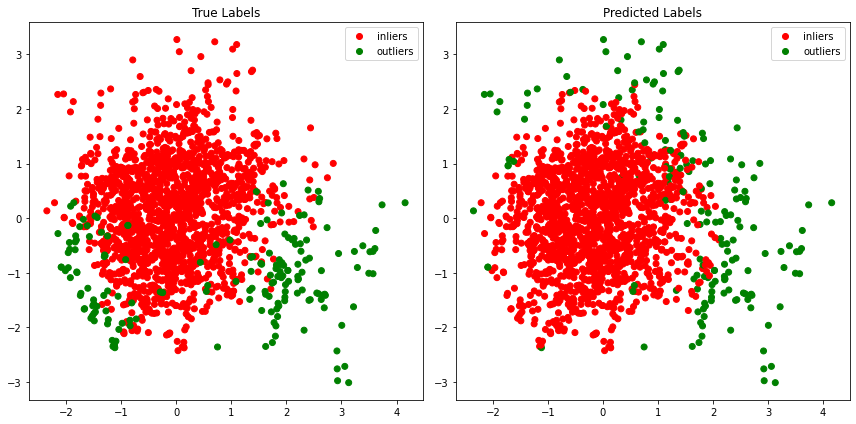

In [35]:
colors = ListedColormap(['red', 'green'])
classes = ['inliers','outliers']

figure, ax = plt.subplots(1,2,figsize=(12,6))

scatter1 = ax[0].scatter(data[:,0], data[:,1], c=y.astype(int), cmap=colors)
ax[0].set_title("True Labels")
ax[0].legend(handles=scatter1.legend_elements()[0], labels=classes)
scatter2 = ax[1].scatter(data[:,0], data[:,1], c=labels, cmap=colors)
ax[1].set_title("Predicted Labels")
ax[1].legend(handles=scatter2.legend_elements()[0], labels=classes)
plt.tight_layout()
plt.show()